In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

## Star Dataset from: 
https://www.kaggle.com/datasets/deepu1109/star-dataset

Brown Dwarf -> Star Type = 0

Red Dwarf -> Star Type = 1

White Dwarf-> Star Type = 2

Main Sequence -> Star Type = 3

Supergiant -> Star Type = 4

Hypergiant -> Star Type = 5

In [3]:
df = pd.read_csv("stars.csv")
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


## Simple preprocessing

In [34]:
import re

# df.isnull().sum()
# df["Star type"].unique()

# print(df[df['Star color'] == "Blue-white"]["Star type"])
# print(df[df['Star color'] == "Blue White"]["Star type"])

def preprocess_color(color_name):
  new_name = color_name.replace(" ", "-").lower()
  if new_name[-1] == '-':
    new_name = new_name[:-1]
  if new_name == "yellow-white":
    new_name = "white-yellow"
  return new_name

# print(df['Star color'].value_counts())

# Fix some color names
df['Star color'] = df['Star color'].apply(preprocess_color)

# Move 'Star type' column to the end
df = df[[col for col in df if col not in ['Star type']] + ['Star type']]
print(df.dtypes)

star_color_categories = df['Star color'].unique()
spectral_class_categories = df['Spectral Class'].unique()

# data = [8, 8, 9, 12, 13, 13, 14, 14, 15, 18, 22, 23, 24, 25, 30]
# fig, ax = plt.subplots()
# ax.hist(df["Star color"], edgecolor="black")``

Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star color                 object
Spectral Class             object
Star type                   int64
dtype: object


## Look for correlations between variables (i.e. multicollinearity)
- ### Using correlation matrix + VIF

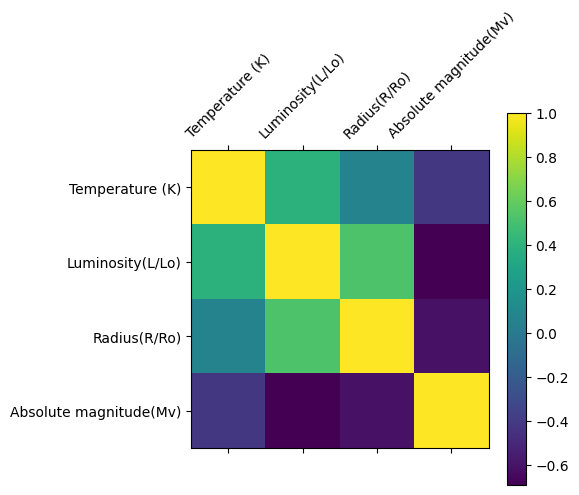

                 features       VIF
0         Temperature (K)  1.371355
1        Luminosity(L/Lo)  2.086649
2            Radius(R/Ro)  1.810867
3  Absolute magnitude(Mv)  2.558650
4                   const  5.433386


In [73]:
numeric_columns = [col for col in df if col not in ['Star type', 'Spectral Class', 'Star color']]
plt.matshow(df[numeric_columns].corr())
plt.xticks(range(4), numeric_columns, rotation=45)
plt.yticks(range(4), df[numeric_columns])
plt.colorbar()
plt.show()

# ohe = OneHotEncoder(sparse_output=False)
# encoded = ohe.fit_transform(df[["Spectral Class", "Star color"]].values)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# X = np.concatenate([df[numeric_columns].values, encoded], axis=1)
X = df[numeric_columns].values
X = np.concatenate([X, np.ones((X.shape[0],1))], axis=1) # Add ones to last column for VIF to work https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

vif = pd.DataFrame({
    "features": numeric_columns + ["const"],
    "VIF": pd.Series([variance_inflation_factor(X, i) for i in range(X.shape[1])])
})

print(vif)

## Hertzsprung-Russell Diagram 

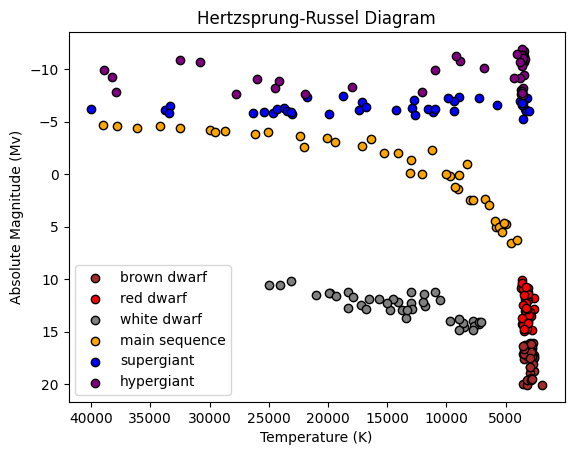

In [117]:
labels = ["brown dwarf", "red dwarf", "white dwarf", "main sequence", "supergiant", "hypergiant"] # from repo https://github.com/ACM-Research/coding-challenge-2023-spring

colors = ["brown", "red", "grey", "orange", "blue", "purple"]    

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Temperature (K)")
plt.ylabel("Absolute Magnitude (Mv)")
plt.title("Hertzsprung-Russel Diagram")
for i in range(6):
    filtered = df[df["Star type"] == i]
    plt.scatter(x=filtered["Temperature (K)"], y=filtered["Absolute magnitude(Mv)"], c=colors[i], label=labels[i], edgecolors="black")        
plt.legend()
plt.show()

## Plot histograms for each feature and it's corresponding star type

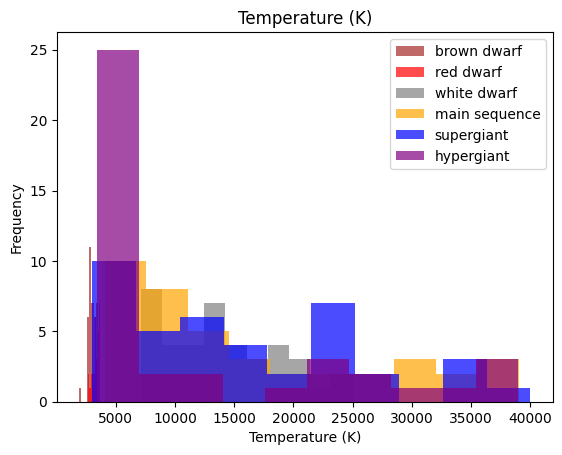

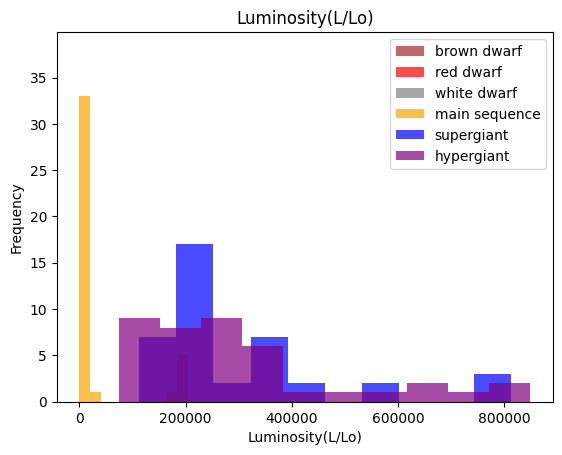

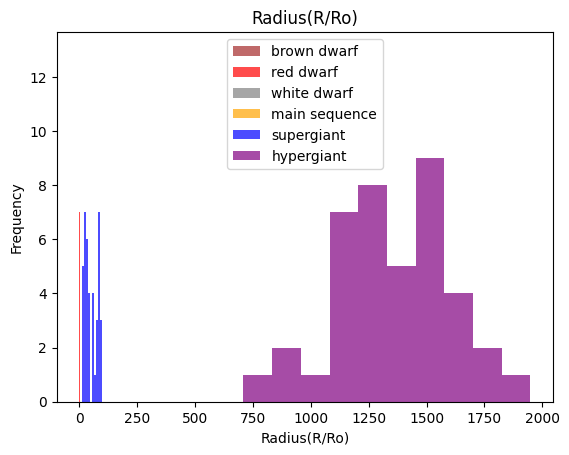

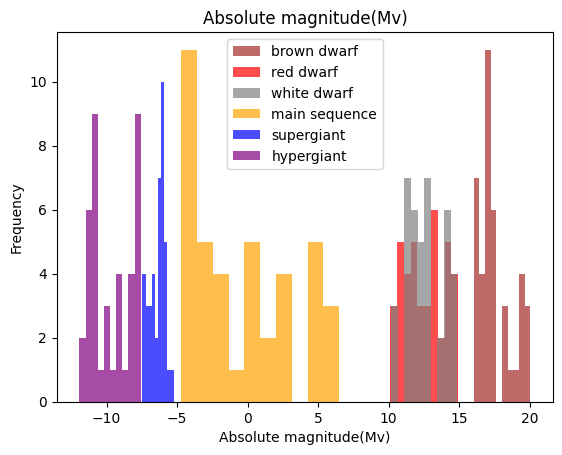

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


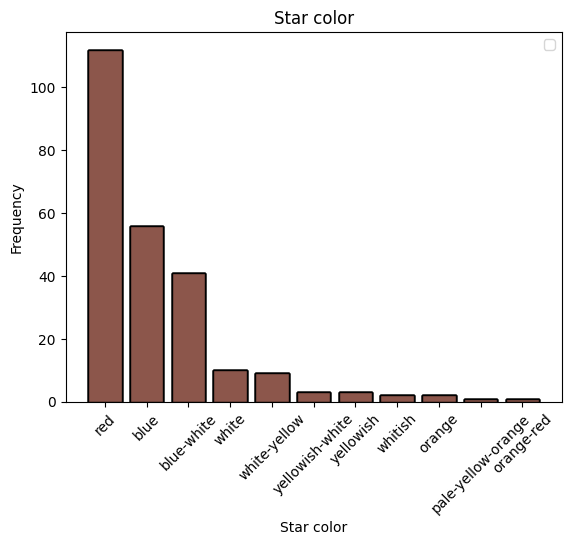

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


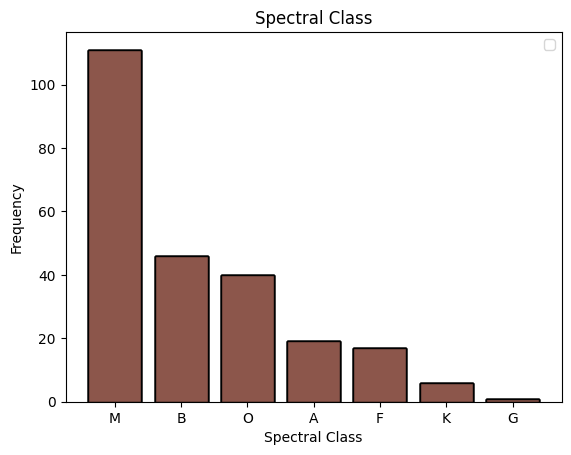

In [120]:
for label in df.columns:
  # Plot histogram of each column for each star type
  if label == "Star type":
    continue  
  else:     
    for star_type in range(6): # Plot a histogram to compare current column with each star type
      if label == "Star color" or label == "Spectral Class": # Just plot a simple bar chart for categorical
        if label == "Star color":
          plt.xticks(rotation=45)
        plt.bar(df[label].value_counts().index, df[label].value_counts().values, edgecolor="black")
      else:        
        plt.hist(df[df['Star type'] == star_type][label], color=colors[star_type], label=labels[star_type], alpha=0.7, density=False) 
  plt.legend()            
  plt.ylabel("Frequency")
  plt.title(label)
  plt.xlabel(label)  
  plt.show()

# Train, validation, test datasets

In [13]:
train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) # 60-20-20
# for i in range(6):
#     print(len(train[train["Star type"] == i]))

In [50]:
from pandas import DataFrame

def preprocess(dataframe: DataFrame, oversample=False, categorical=False):  
  columns_to_scale = ["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"]    
  
  scaler = StandardScaler()      
  
  X = scaler.fit_transform(dataframe[columns_to_scale].values)    
  
  if categorical:
    columns_to_encode = ["Star color", "Spectral Class"]
    ohe = OneHotEncoder(sparse_output=False, categories=[star_color_categories, spectral_class_categories])
    encoded = ohe.fit_transform(dataframe[columns_to_encode])  
    X = np.concatenate([X, encoded], axis=1)
    
  y = dataframe["Star type"].values    
  
  if oversample: # Likely not necessary here
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)
    
  # all_columns = np.concatenate((columns_to_scale, ohe.get_feature_names_out(columns_to_encode), ["Star type"]))  
  # print(pd.DataFrame(np.hstack((X, np.reshape(y, (-1, 1)))), columns=all_columns).head())
    
  return np.hstack((X, np.reshape(y, (-1, 1)))), X, y

train, X_train, y_train = preprocess(train_df)
valid, X_valid, y_valid = preprocess(valid_df, categorical=True)
test, X_test, y_test = preprocess(test_df)

print(train.shape)
print(valid.shape)
print(test.shape)
# for i in range(6):
#     print(sum(y_train == i))

(144, 5)
(48, 23)
(48, 5)


# KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score

In [43]:
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

**Precision: True Positives / (True Positives + False Positives)**
- how precise the classifier is whenever it predicts a certain class

**Recall: True Positives / (True Positives + False Negatives)**
- percent of correctly identified classes

**F1 Score: 2 * (Precision * Recall) / (Precision + Recall)**
- harmonic mean of precision and recall, gives the percent of correct positive predictions

In [44]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.71      1.00      0.83         5
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9

    accuracy                           0.96        48
   macro avg       0.95      0.97      0.95        48
weighted avg       0.97      0.96      0.96        48

